# Vote Org

|   About the script    |                                         |
| ----------- | --------------------------------------- |
| Last update |  Dec 4 2019 |
| Experiment  | Vote.org Hustle SMS GOTV Test Result  |
| Dataset     | merge `raw_messages_hustle.csv` and `vdo_hustle_gotv_outcome including phone number for merging purposes.csv`|


|    Available covariates   |      |
| ----------- | --------------------------------------- |
| 2 General Elections Turnout|  2008, 2012  |
|demographical Profile|  age, gender, race, marrige|
| Vote Propensity | predicted by logit regression using voting history |

In [1]:
# load libraries

# data cleaning and reshape
import pandas as pd
import numpy as np

# caculate standard error
from scipy.stats import sem

# regression
import statsmodels.api as sm
# regression use formualar
import statsmodels.formula.api as smf
# regression with clustered standard error
import econtools.metrics as mt

# plot display
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# supress warning inline
import warnings
warnings.filterwarnings('ignore')

# display and export regression table
from stargazer.stargazer import Stargazer

# display latex and html table
from IPython.display import Latex
from IPython.display import HTML

In [2]:
# set random seed to ensure the following code and result is replicable
np.random.seed(2019)

In [4]:
df = pd.read_csv('../../Machine Learing HTE/1_data/org_hustle/org_hustle_add.csv')

In [3]:
# df =pd.read_csv("../../Machine Learing HTE/1_data/org_hustle/vdo_hustle_gotv_outcome including phone number for merging purposes.csv")

## clean dataset

In [4]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [5]:
a = pd.crosstab(df.dma_name.str.extract('([A-Z]{2})', expand = False), df.gender)

In [6]:
a = a.sort_values('Female', ascending=False).\
rename_axis(index={'dma_name': 'States'},
             columns = {'gender': 'Gender'})

In [7]:
p_latex(a, 'Vote.org Experiment Target')

<IPython.core.display.Latex object>

In [8]:
#create assigned to texting condition variable
df['treat_binary'] = np.where(df.assign_treat == "Control", 0, 1)

In [9]:
df['voted']= np.where(df.vf_g2016.isna(), 0, 1)

In [10]:
df.vf_g2008 = np.where(df.vf_g2008.isna(), 0, 1)
df.vf_g2012 = np.where(df.vf_g2012.isna(), 0, 1)

In [11]:
for c in ['gender','race', 'marital_status']:
    drop_level = c+'_'+df[c].unique()[0]    
    dummy=pd.get_dummies(df[c],prefix=c).drop(labels=drop_level,axis=1)
    df=pd.concat([df,dummy], axis=1)

In [12]:
df.voted.mean()

0.5225400806416879

In [13]:
df.columns

Index(['voterfile_id', 'hh_id', 'turnout_score', 'age', 'age_blk', 'gender',
       'race', 'marital_status', 'dma', 'dma_name', 'dma_count', 'hh_n',
       'multi_person_hh', 'hh_rep', 'assign_treat', 'strata', 'vf_g2008',
       'vf_g2012', 'vf_g2016', 'phone_number', 'treat_binary', 'voted',
       'gender_Male', 'gender_Unknown', 'race_AAPI', 'race_Black',
       'race_Hispanic', 'race_Other', 'marital_status_Married',
       'marital_status_Unknown'],
      dtype='object')

In [14]:
df['assignment'] = df.assign_treat.replace( to_replace=['Plan Plus Poll', 'Plan Only', 'Control', 'Poll Location'],
    value=['Polling location', 'Plan-making', 'Control', 'Polling location'])

In [15]:
# description of assignment and compliance
def f(x):
    d = {}
    d['Group Size'] = x['assignment'].count()
    d['Proportion to Subject Pool'] =  x['assignment'].count()/df.shape[0] 
    d['Turnout'] = x['voted'].mean()

    return pd.Series(d, index=[ 'Group Size',
                               'Proportion to Subject Pool',
                              'Turnout'])

In [16]:
c = df[['assignment','voted']].groupby('assignment').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

In [17]:
c

,Group Size,Proportion to Subject Pool,Turnout
Assignment,,,
Control,301920.0,0.250075,0.521194
Plan-making,301751.0,0.249935,0.520519
Polling location,603645.0,0.499989,0.524224


In [18]:
p_latex(c, 'Treatment Assignment in Vote.org Experiment')

<IPython.core.display.Latex object>

In [19]:
# description of assignment and compliance
def f(x):
    d = {}
    d['Group Size'] = x['treat_binary'].count()
    d['Proportion to Subject Pool'] =  x['treat_binary'].count()/df.shape[0] 
    d['Turnout'] = x['voted'].mean()

    return pd.Series(d, index=[ 'Group Size',
                               'Proportion to Subject Pool',
                              'Turnout'])

In [20]:
b = df[['treat_binary','voted']].groupby('treat_binary').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

In [21]:
p_latex(b, 'Receiving a Message in Vote.org Experiment')

<IPython.core.display.Latex object>

## Vote Propensity: The probability of voting based on vote history

In [22]:
df.shape

(1207316, 31)

In [23]:
vote_list = ['vf_g2008','vf_g2012', "age",
       'gender_Male', 'gender_Unknown', 'race_AAPI', 'race_Black',
       'race_Hispanic', 'race_Other','marital_status_Married',
       'marital_status_Unknown']

pro_data = df.loc[:,[ 'treat_binary','voted', *vote_list]]

In [24]:
y = pro_data[pro_data.treat_binary==0].voted.astype(int)

X = pro_data[pro_data.treat_binary==0][vote_list]

In [25]:
# Creat interaction term between vote histories
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_in = poly.fit_transform(X)

from sklearn.linear_model import LogisticRegression
#Note: logistic regression in sklearn is preset to be a regularization model with C=100).
# C is the tuning parameter like alpha in Reidge and Lasso regression Reguilization
logreg = LogisticRegression(C=1e90).fit(X_in, y)

In [26]:
all_in=poly.fit_transform(pro_data[vote_list])

vp = logreg.predict_proba(all_in)

vp_df = pd.DataFrame(data={'vote_propensity': vp[:,1]}, index = pro_data.index)

df = pd.merge(df, vp_df,left_index=True,
    right_index=True,how='left')

In [27]:
import matplotlib.pyplot as plt

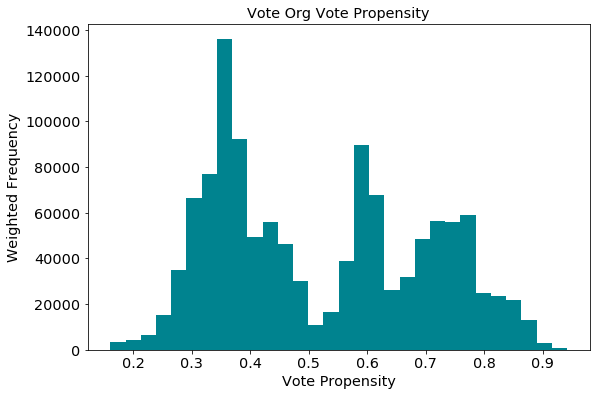

In [7]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure(figsize=(9,6))
ax = plt.hist(df.vote_propensity, 
         30,color='#00838f')
plt.xlabel("Vote Propensity")
plt.ylabel("Weighted Frequency")
plt.title("Vote Org Vote Propensity") # You can comment this line out if you don't need title
plt.show(ax)

In [16]:
# Cut vote propensity score into 10 bins
df['vp_10']=pd.cut(df.vote_propensity, np.arange(0,1.1,0.1))

def get_bins_table():
    pd.options.display.float_format = '{:.3%}'.format
    a = df[['vp_10','voted','treat_binary']].\
    groupby(['vp_10',"treat_binary"]). \
    voted.agg([('Size','count'),
              ('Turnout',np.mean),
              ('Proportion', lambda x: x.count()/df[df.vote_propensity.isna()==False].shape[0])]).reset_index()
    
    b = df[['vp_10','voted','treat_binary']].\
    groupby(['vp_10',"treat_binary"]). \
    voted.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index().groupby('vp_10').Turnout.agg([('Effect','diff')])
    
    r = pd.concat([a,b], axis=1)
    r.rename(columns={'vp_10': 'Vote Propensity Range'}, inplace = True)
    r.Effect.fillna(" ", inplace=True)
    r.treat_binary.replace([0,1],['Control', 'Treatment'], inplace=True)
    return r

In [17]:
get_bins_table()

,Vote Propensity Range,treat_binary,Size,Turnout,Proportion,Effect
0,"(0.1, 0.2]",Control,1367,22.970%,0.113%,
1,"(0.1, 0.2]",Treatment,4057,21.321%,0.336%,-1.649%
2,"(0.2, 0.3]",Control,21207,29.693%,1.757%,
3,"(0.2, 0.3]",Treatment,63134,29.770%,5.229%,0.077%
4,"(0.3, 0.4]",Control,88055,34.096%,7.293%,
5,"(0.3, 0.4]",Treatment,263367,34.246%,21.814%,0.150%
6,"(0.4, 0.5]",Control,44083,44.745%,3.651%,
7,"(0.4, 0.5]",Treatment,132843,45.192%,11.003%,0.447%
8,"(0.5, 0.6]",Control,36287,56.340%,3.006%,
9,"(0.5, 0.6]",Treatment,109045,56.545%,9.032%,0.205%


In [18]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex(index=False).\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

p_latex(get_bins_table(),'Crosstable of Vote Propensity and Turnout in Vote.org')

<IPython.core.display.Latex object>

In [31]:
# Vote trunout by vote propensity socre and treatment assignment
Latex(get_bins_table().to_latex())

<IPython.core.display.Latex object>

## Balance Check

In [35]:
prob_balance = []
prob_balance.append(smf.ols(formula='treat_binary ~ vote_propensity ', data=df).fit())

In [36]:
for var in ['gender','race', 'marital_status']:
    formular = 'treat_binary ~ C('+var+')'
    model = smf.ols(formular , df)
    results = model.fit()
    prob_balance.append(results)

In [37]:
prob_balance.append(smf.ols('treat_binary ~vote_propensity+C(gender)+C(race)+C(marital_status)', data=df).\
fit(cov_type='cluster',cov_kwds={'groups':df['hh_id']}))

In [38]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance Check')
stargazer.custom_columns(['vote propensity','gender','race', 'marital_status', 'all'], [1,1,1,1,1])

HTML(stargazer.render_html())


In [39]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [40]:
df.to_csv('../../Machine Learing HTE/1_data/org_hustle/org_hustle_add.csv', index=False)

## Main Result

In [10]:
ols_cluster = smf.ols(formula='voted ~ treat_binary',
               data=df).fit(cov_type = 'cluster', cov_kwds={'groups': df['hh_id']})

In [11]:
# Categorize variable in formular
ols_report = smf.ols(formula='voted ~ treat_binary+age+C(gender)+C(race)+C(marital_status)+vf_g2008+vf_g2012+turnout_score',
               data=df).fit(cov_type = 'cluster', cov_kwds={'groups': df['hh_id']})

In [12]:
stargazer = Stargazer([ols_cluster, ols_report])
stargazer.significant_digits(4)
stargazer.custom_columns(['OLS', 'Reported Result'], [1,1])
stargazer.covariate_order(['Intercept', 'treat_binary'])
stargazer.title('Main Effect')

In [13]:
HTML(stargazer.render_html())

In [48]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

## Machine Learning

Metalearners are binary treatment Conditional Average Treatment Effect (CATE) estimators, which build on base algorithms such as random forests (RFs), Bayesian additive regression trees (BARTs) to estimate the CATE.

Following the recommendation in [paper](https://arxiv.org/pdf/1706.03461.pdf), we use the Random Forest as the base algorithm for the super-learner (T-learner and X-learner)

Compute potential untreated outcome for treatment group, potential treated outcome for control group, and calculate individual treatment effects (ITEs)


In [32]:
# Outcome: Voter Turn out in 2016
Y = np.array(df['voted'].astype(int))

# Treatment: Text Messaging
T = np.array(df['treat_binary'].astype(int))

# Covariates
X =np.array(df[['vote_propensity']])

# Meta Learner Library
from econml.metalearners import XLearner
# Base Algorithm Library
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

n=X.shape[0]

In [33]:
# Instantiate X learner
controls_model = GradientBoostingRegressor(n_estimators=100, 
                                           max_depth=6, 
                                           min_samples_leaf=int(n/1000))
treated_model = GradientBoostingRegressor(n_estimators=100, 
                                          max_depth=6, 
                                          min_samples_leaf=int(n/1000))
propensity_model = RandomForestClassifier(n_estimators=100, 
                                          max_depth=6, 
                                        min_samples_leaf=int(n/1000),
                                        class_weight='balanced_subsample')
X_learner = XLearner(controls_model=controls_model, 
                     treated_model=treated_model, 
                     propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X)

## Cross tables vote propensity and estimated CATE

In [2]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/org_hustle/org_hustle_with_ITEs.csv')

In [4]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [34]:
learner_df = pd.DataFrame({'Propensity': X[:, 0],
                          'ITE':X_te,
                         'Treatment':T,
                         'Turnout': Y,
             'hh_id': df[df.voted.isna()==False]['hh_id']})

In [5]:
learner_df['Propensity Range']=pd.cut(learner_df['Propensity'], np.arange(0,1.1,0.1))

# Vote trunout by vote propensity socre and treatment assignment

ct_ite = learner_df.\
groupby(['Propensity Range']).ITE. \
agg({
     'ITE':[('Average ITE',np.mean),
                         ('Group Size','count'),
                         ('Proportion to Total', lambda x: x.size/1207316)]})

In [6]:
pd.options.display.float_format = '{:.3%}'.format

p_latex(ct_ite, "Cross table between vote propensity and estimated ITE (Vote.org)")

<IPython.core.display.Latex object>

## Fit on Estimated CATE

In [7]:
learner_df['Propensity_square'] = learner_df.Propensity*learner_df.Propensity

y = learner_df['ITE']

X = learner_df[['Propensity']]
X = sm.add_constant(X)

ols = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})

X = learner_df[['Propensity_square','Propensity']]
X = sm.add_constant(X)

ols2 = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})


stargazer = Stargazer([ols, ols2])
stargazer.significant_digits(4)
stargazer.title('Regress ITE on Vote Propensity (Vote.org)')

HTML(stargazer.render_html())

In [12]:
0.0123/(-2*(-0.0128))

0.48046875

In [8]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [38]:
learner_df.to_csv('../../Machine Learing HTE/1_data/org_hustle/org_hustle_with_ITEs.csv', index=False)

In [9]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': '18',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

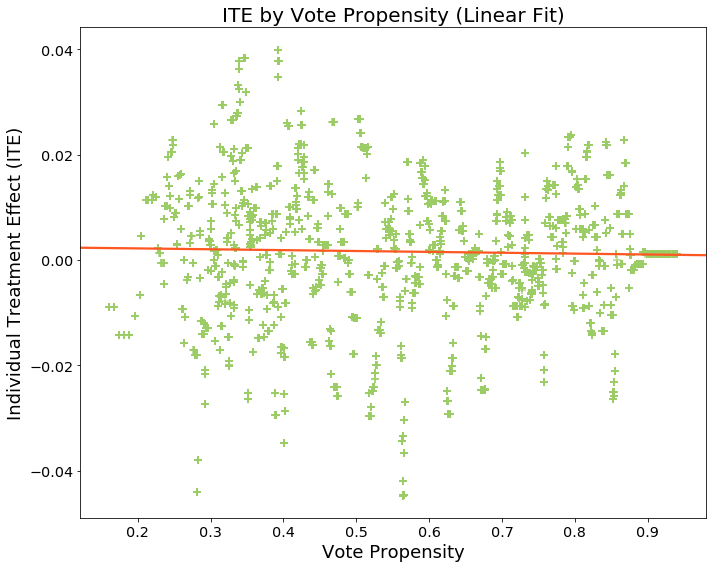

In [10]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=1,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#9CCC65',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('ITE by Vote Propensity (Linear Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('Vote org with Line', dpi=800)

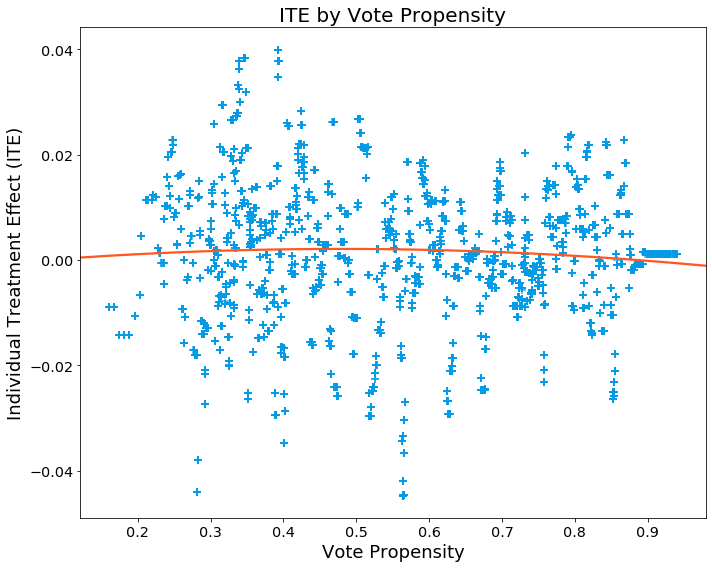

In [11]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=2,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#039be5',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('ITE by Vote Propensity',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('Vote org with Parabola', dpi=800)

### Sigmoid Fit

(array([ 13612., 117025., 285866., 171163.,  57408., 194266., 105791.,
        174729.,  69732.,  17724.]),
 array([0.16066216, 0.23859447, 0.31652677, 0.39445908, 0.47239138,
        0.55032369, 0.62825599, 0.7061883 , 0.7841206 , 0.86205291,
        0.93998521]),
 <a list of 10 Patch objects>)

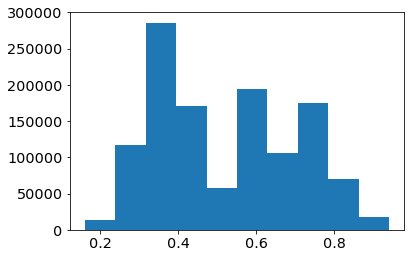

In [10]:
plt.hist(learner_df.Propensity)

In [9]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square
0,0.354652,0.005716,1,0,3033 OLYMPIC CLUB DR43147,"(0.3, 0.4]",0.125778
1,0.492310,-0.006049,1,0,16 CREEKWOOD DR63376,"(0.4, 0.5]",0.242369
2,0.703032,-0.000663,0,0,7322 E NARANJA AVE85209,"(0.7, 0.8]",0.494254
3,0.353765,0.002496,0,0,105 THOMAS DR17404,"(0.3, 0.4]",0.125150
4,0.348812,0.021242,1,0,157 E GOODLAND ST53590,"(0.3, 0.4]",0.121670


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
    # a adjusts amplitude
    # b adjusts y offset
    # c adjusts x offset
    # d adjusts slope
    return ((a - b) / (1. + np.exp(x - (c / 2)) ** d)) + b


xdata = np.array(learner_df.Propensity)
ydata = np.array(learner_df.ITE)

In [14]:
max(xdata)

0.939985213741518

In [17]:
p0 = [ max(ydata),min(ydata),min(xdata), 1]

In [ ]:
# fit the data
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)

In [ ]:
popt

In [ ]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')

# plot the result
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='fit')

plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Vote org AZ ITE by Vote Propensity (Sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.show()

In [81]:
X = learner_df[['Propensity']]
X = sm.add_constant(X)

In [82]:
from sklearn.metrics import mean_squared_error

In [83]:
ols_mse = mean_squared_error(ydata, np.array(ols.predict(X)))
sig_mes = mean_squared_error(ydata, np.array(sigmoid(xdata, *popt)))

In [84]:
'linear fit MSE: {:.6f}'.format(ols_mse)

'linear fit MSE: 0.000105'

In [85]:
'Sigmoid fit MSE: {:.6f}'.format(sig_mes)

'Sigmoid fit MSE: 0.000105'

In [86]:
'Sigmoid fit reduce MSE by {:.2%}'.format(1-sig_mes/ols_mse)

'Sigmoid fit reduce MSE by -0.00%'

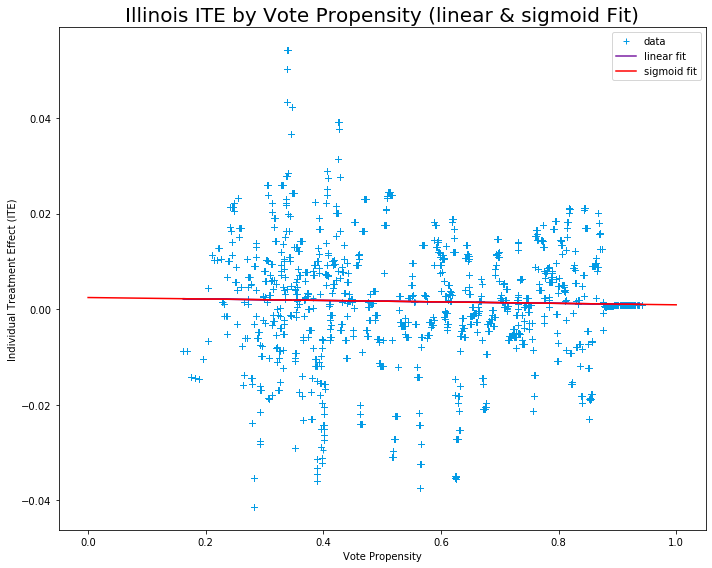

In [87]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')

# plot linear fit
plt.plot(xdata, np.array(ols.predict(X)), '-',c='#7b1fa2', label='linear fit')

# plot sigmoid fit
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='sigmoid fit')


plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Illinois ITE by Vote Propensity (linear & sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('NGA IL with both fit', dpi=800)
plt.show()

# Simulation

In [3]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity Range,Propensity_square
0,0.354652,0.005716,1,0,3033 OLYMPIC CLUB DR43147,"(0.3, 0.4]",0.125778
1,0.492310,-0.006049,1,0,16 CREEKWOOD DR63376,"(0.4, 0.5]",0.242369
2,0.703032,-0.000663,0,0,7322 E NARANJA AVE85209,"(0.7, 0.8]",0.494254
3,0.353765,0.002496,0,0,105 THOMAS DR17404,"(0.3, 0.4]",0.125150
4,0.348812,0.021242,1,0,157 E GOODLAND ST53590,"(0.3, 0.4]",0.121670


In [4]:
learner_df.Treatment.value_counts()

1    905396
0    301920
Name: Treatment, dtype: int64

In [5]:
sim = learner_df.sort_values('Propensity',ascending=False ).reset_index(drop=True)

In [6]:
sim.Treatment.value_counts()

1    905396
0    301920
Name: Treatment, dtype: int64

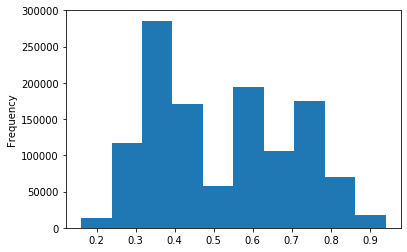

In [7]:
sim.Propensity.plot('hist')

In [8]:
sim.loc[0:905396,'sim_treat'] = 1

sim.loc[905396:,'sim_treat'] = 0

In [9]:
X = sim[['sim_treat']]

X = sm.add_constant(X)

y = sim['ITE']

In [10]:
sm_az = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

In [11]:
X = sim[['Treatment']]

X = sm.add_constant(X)

y = sim['ITE']

In [12]:
ite_il = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

In [13]:
stargazer = Stargazer([ite_il,sm_az])
stargazer.significant_digits(4)
stargazer.title('ITE vs Simulation (Vote.org)')
stargazer.covariate_order(['const',  'Treatment','sim_treat'])

stargazer.rename_covariates({'const': 'Intercept',
                            'sim_treat': 'Optimized Alloaction'})


stargazer.custom_columns(['Treatment Assignment', 'Optimized'], [1,1])
HTML(stargazer.render_html())

In [14]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>